# Beta hedging concentrates exposure to alpha

Portfolio managers design factor models that tell them how to balance a portfolio to earn alpha. Because alpha is how managers get paid, they only want exposure to their factors. Beta hedging removes the part of returns driven by the market and leaves only the returns driven by the factors.

If this sounds complicated there’s good news: You can hedge beta with the same linear regression.

By the end of this issue, you’ll know how to:

1. Get data for stock and benchmark
2. Find a portfolio’s alpha and beta
3. Hedge beta

In [1]:
# Step 1: Get the data

# Start by importing the libraries. statsmodels is a package used to build statistical models like linear regression.

import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
# Next, get the data. I use TSLA as an example of a stock portfolio. You can use actual portfolio returns instead.

data = yf.download("TSLA, SPY", start="2014-01-01", end="2015-01-01")

asset = data["Adj Close"].TSLA
benchmark = data["Adj Close"].SPY

[*********************100%***********************]  2 of 2 completed


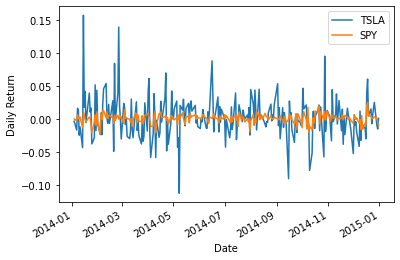

In [2]:
# Finally, get the returns and plot them.

asset_returns = asset.pct_change().dropna()
benchmark_returns = benchmark.pct_change().dropna()

asset_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()

In [3]:
# Step 2: Find the portfolio’s alpha and beta

# Linear regression models have an alpha term and one or more beta terms (plus an error). Alpha is the intercept and beta is the slope of the line that minimizes the error between all the points on a scatter plot. This will be clear when you see the chart.

# But first, build the code.

X = benchmark_returns.values
Y = asset_returns.values

def linreg(x, y):
    # Add a column of 1s to fit alpha
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0009171538333268448
Beta: 1.95415980651142


Linreg accepts two inputs: the independent variable (market returns) and the dependent variable (portfolio returns). Inside the function, add a column of 1s so statsmodels can find the alpha term. Then run the model and return the alpha and beta.

The alpha should be near 0. This means that by owning TSLA alone, you’re not beating the benchmark. The beta is 1.95. This means for every 1% the benchmark moves, TSLA moves 1.95% in the same direction.

Plot the returns and the regression line.

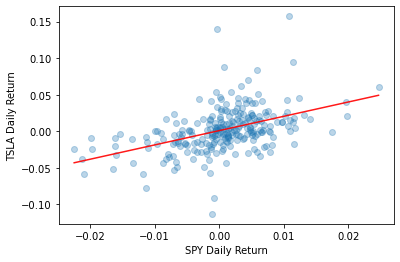

In [4]:
# Plot the returns and the regression line.

X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

# Plot the raw data
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

# Add the regression line
plt.plot(X2, Y_hat, 'r', alpha=0.9);

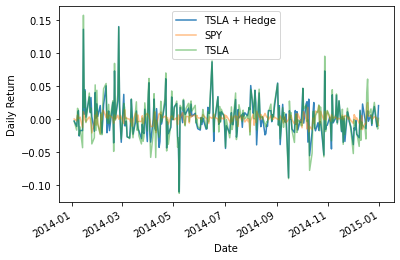

In [5]:
# Step 3: Hedge beta

# Because you’re only interested in exposure to the returns generated by owning TSLA, hedge the beta. Hedging beta will result in a portfolio with returns close to 0 because alpha is close to 0.

# The first step is to construct a beta-hedged portfolio.

portfolio = -1 * beta * benchmark_returns + asset_returns
portfolio.name = "TSLA + Hedge"
# This says “be short a number of shares in the market equal to the beta plus TSLA.”

# Since we’re beta hedged (market neutral) you should expect that the portfolio returns closely resemble that of TSLA. In other words, your exposure is concentrated in your source of alpha.

portfolio.plot(alpha=0.9)
benchmark_returns.plot(alpha=0.5);
asset_returns.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

In [6]:
# It looks like the portfolio return follows the asset. Run the regression the the portfolio to make sure you removed the beta while keeping the alpha.

P = portfolio.values
alpha, beta = linreg(X, P)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0009171538333268448
Beta: -6.16030307722036e-16
